In [1]:
import sys
import os
sys.path.append(os.getcwd()+"/../..")
from src import paths

from src.utils import get_default_pydantic_model, SideEffect, SideEffectList

import pandas as pd
import torch

import json

import numpy as np

from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

default_model = get_default_pydantic_model("side_effects")
model = BertModel.from_pretrained(os.path.join(paths.MODEL_PATH, "medbert-512")).to(device)
tokenizer = BertTokenizer.from_pretrained(os.path.join(paths.MODEL_PATH, "medbert-512"))

Some weights of BertModel were not initialized from the model checkpoint at /cluster/dataset/midatams/inf-extr/resources/models/medbert-512 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def high_cosine_similarity(ground_truth:str, prediction:str, model:BertModel, tokenizer:BertTokenizer, threshhold:float = 0.7):
    """
    Calculate if the cosine similarity between the ground truth and the prediction is higher than the threshhold.

    Args:
        ground_truth (str): The ground truth text.
        prediction (str): The predicted text.
        model (BertModel): BertModel object to calculate the cosine similarity.
        tokenizer (BertTokenizer): BertTokenizer object to tokenize the text.
        threshhold (float, optional): The threshhold for the cosine similarity. Defaults to 0.7.

    Returns:
        bool: True if the cosine similarity is higher than the threshhold, False otherwise.
    """

    with torch.no_grad():
        ground_truth = model(**tokenizer(ground_truth, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device))["last_hidden_state"].to("cpu")
        prediction = model(**tokenizer(prediction, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device))["last_hidden_state"].to("cpu")
        ground_truth = ground_truth.mean(dim=1)
        prediction = prediction.mean(dim=1)
        return cosine_similarity(ground_truth, prediction).item() >= threshhold

def preprocess_group(grouped_df: pd.DataFrame)->pd.DataFrame:
    """
    Preprocess a group of rows (grouped by obs index) from the dataframe. The preprocessing consists of:
    - Fusing all the unique side effects per medication with "," (so only one row per medication is left)
    - Splitting the medications by "/" if necessary

    Args:
        grouped_df (pd.DataFrame): A group of rows from the dataframe.

    Returns:
        pd.DataFrame: A dataframe with the group preprocessed.
    """

    df = []
    
    # group by medication name
    for med, group in grouped_df.groupby("medication"):
       # Fuse all the unique side effects with ","
        side_effects = group["side_effect"].unique()
        side_effects = ", ".join(side_effects)
        text = group["text"].iloc[0]
        original_text = group["original_text"].iloc[0]
        index = group["index"].iloc[0]

        new_row = {"medication": med, "side_effect": side_effects, "text": text, "original_text": original_text, "index": index, "successful": group["successful"].iloc[0]}
        # Append the new row to the dataframe
        df.append(new_row)

    return pd.DataFrame(df)

def prepare_results(path: str)->pd.DataFrame:
    """ 
    Prepare the results from the model to be compared with the labels. The preprocessing consists of:
    - Fixing the model answers, replacing them with the default model answer if they are invalid (in regards to JSON structure).
    - Grouping the results by index and preprocessing the group. (See preprocess_group() function for more details.)
    - Lowercasing and converting everything to string.

    Args:
        path (str): Path to the results file.
        
    Returns:
        pd.DataFrame: A dataframe with the results preprocessed.
    """
    results = torch.load(path)
    df = pd.DataFrame(results)

    df["successful"] = True

    # Fix model_answers
    for idx, row in df.iterrows():
        try:
            # Does model answer have key "side_effects"?
            answer = json.loads(row["model_answers"])

            # Is answer a valid SideEffectList?
            SideEffectList(**answer)

            # Is the element an empty list?
            if len(answer["side_effects"]) == 0:
                raise ValueError("Empty list")
            
            # Are all the elements valid SideEffect?
            for med in answer["side_effects"]:
                SideEffect(**med)
            
            df.at[idx, "model_answers"] = json.dumps(answer)

            
        except:
            df.at[idx, "model_answers"] = default_model.model_dump_json()
            # print(f"Error at index {idx}")
            df.at[idx, "successful"] = False
    
    dfs = []
    for idx, row in df.iterrows():
        row = row.to_dict()
        answer = json.loads(row["model_answers"])
        medications = answer["side_effects"]
        for med in medications:
            med["text"] = row.get("text", "")
            med["original_text"] = row.get("original_text", "")
            med["index"] = row.get("index", "")
            med["successful"] = row.get("successful", "")
            dfs.append((med))

    res = pd.DataFrame(dfs)

    res = res.sort_values(by="index")

    # Group by index and preprocess
    _dfs = []

    for index, group in res.groupby("index"):
        _dfs.append(preprocess_group(group))

    res = pd.concat(_dfs)

    # Convert everything to string and lowercase
    res = res.map(lambda x: str(x).lower())

    return res

def prepare_labels(path: str)->pd.DataFrame:
    """
    Prepare the labels to be compared with the results. The preprocessing consists of:
    - Lowercasing and converting everything to string.

    Args:
        path (str): Path to the labels file.

    Returns:

        pd.DataFrame: A dataframe with the labels preprocessed.
    """
    labels = pd.read_excel(path) 

    # Convert everything to string and lowercase
    labels = labels.map(lambda x: str(x).lower())

    return labels

def calculate_precision_recall_f1(ground_truth:list[str], predicted:list[str])->tuple[float, float, float]:
    """
    Calculate precision and recall from two lists of strings, allowing for partial string matches.
    A string does not have to be exactly the same to be considered a match, it is enough if one string is a substring of the other.
    This function is used to evaluate the medication names.

    Args:
        ground_truth (list[str]): List of ground truth medication names
        predicted (list[str]): List of predicted medication names

    Returns:
        tuple[float, float, float]: A tuple with the precision, recall and f1 score.
    """
    # Convert lists to sets for easier comparison
    ground_truth_set = set(ground_truth)
    predicted_set = set(predicted)

    # Initialize counters
    true_positives = 0
    false_positives = 0

    # Calculate True Positives and False Positives
    for pred_med in predicted_set:
        found_match = False
        for truth_med in ground_truth_set:
            if pred_med in truth_med or truth_med in pred_med:
                true_positives += 1
                found_match = True
                break
        if not found_match:
            false_positives += 1

    # Calculate False Negatives
    false_negatives = len(ground_truth_set) - true_positives

    # Calculate Precision
    if true_positives + false_positives == 0:
        precision = 0  # Handle division by zero
    else:
        precision = true_positives / (true_positives + false_positives)

    # Calculate Recall
    if true_positives + false_negatives == 0:
        recall = 0  # Handle division by zero
    else:
        recall = true_positives / (true_positives + false_negatives)

    # Calculate F1 Score
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

def string_match(ground_truth:list[dict], predicted:list[dict], model:BertModel, tokenizer:BertTokenizer, threshold:float=0.9)->tuple[float, float, float]:
    """ 
    Calculate if the strings match (based on cosine similarity) from two lists of dictionaries. This function is used to evaluate the side effects.

    Args:
        ground_truth (list): List of ground truth medication names and their side effect.
        predicted (list): List of predicted medication names and their side effect.
        model (BertModel): BertModel object to calculate the cosine similarity.
        tokenizer (BertTokenizer): BertTokenizer object to tokenize the text.
    """

    # Match the prediction to the ground truth with medication name
    tp = 0
    fn = 0
    fp = 0

    for pred_id, pred in enumerate(predicted):
        for gt_id, gt in enumerate(ground_truth):
            if pred["medication"] in gt["medication"] or gt["medication"] in pred["medication"]:
                if high_cosine_similarity([pred["side_effect"]], [gt["side_effect"]], model, tokenizer, threshold):
                    tp += 1
                else:
                    fp += 1
                    fn += 1
                # Remove the ground truth and prediction from the list
                ground_truth.pop(gt_id)
                predicted.pop(pred_id)

    # For remaining ground truth
    fn += len(ground_truth)
    fp += len(predicted)

    # Calculate Precision
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    # Calculate Recall
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    # Calculate F1 Score
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1


def create_metrics_df(labels_path:str, results_path:str, *args, **kwargs)->pd.DataFrame:
    """
    Create a dataframe with the metrics for each index. The metrics are:
    - Precision, Recall and F1 score for medication names
    - Precision, Recall and F1 score for side effects

    Args:
        labels_path (str): Path to the labels file.
        results_path (str): Path to the results file.

    Returns:
        pd.DataFrame: A dataframe with the metrics for each index.
    """
    
    labels = prepare_labels(labels_path)
    res = prepare_results(results_path)
    model = kwargs.get("model")
    tokenizer = kwargs.get("tokenizer")
    threshold = kwargs.get("threshold", 0.9)

    dfs = []
    for index, group in res.groupby("index"):
        text = group["text"].iloc[0]
        original_text = group["original_text"].iloc[0]
        index = group["index"].iloc[0]
        preds_med = group["medication"].to_list()
        preds_se = group["side_effect"].to_list()
        labels_med = labels[labels["index"] == index]["medication"].to_list()
        labels_se = labels[labels["index"] == index]["side_effect"].to_list()

        # Side effects
        ground_truth = labels[labels["index"] == index].to_dict(orient="records")
        predicted = group.to_dict(orient="records")
        assert model is not None and tokenizer is not None, "Model and tokenizer must be provided as keyword arguments for side effects evaluation."
        side_effects_precision, side_effects_recall, side_effects_f1 = string_match(ground_truth, predicted, model, tokenizer, threshold)

        # Medication
        ground_truth = labels[labels["index"] == index]["medication"].to_list()
        predicted = group["medication"].to_list()
        medication_precision, medication_recall, medication_f1 = calculate_precision_recall_f1(ground_truth, predicted)

        
        if group["successful"].iloc[0] == "false":
            successful = False
        else:
            successful = True

        dfs.append({"text": text, 
                    "original_text": original_text, 
                    "index": index, 
                    "preds_med": preds_med,
                    "labels_med": labels_med,
                    "preds_se": preds_se,
                    "labels_se": labels_se,
                    "successful": successful,
                    "side_effects_precision": side_effects_precision, "side_effects_recall": side_effects_recall, "side_effects_f1": side_effects_f1, "medication_precision": medication_precision, "medication_recall": medication_recall, "medication_f1": medication_f1})

    return pd.DataFrame(dfs)

def create_agg_metrics_df(labels_path:str, results_path:str, *args, **kwargs)->pd.DataFrame:
    """
    Create a dataframe with the aggregated metrics for the whole dataset. The metrics are:
    - Precision, Recall and F1 score for medication names
    - Precision, Recall and F1 score for side effects

    Args:
        labels_path (str): Path to the labels file.
        results_path (str): Path to the results file.
        scorer (BERTScorer): BERTScorer object to score the similarity between the side effects.

    Returns:
        pd.DataFrame: A dataframe with the aggregated metrics for the whole dataset.
    """
    metrics = create_metrics_df(labels_path, results_path, *args, **kwargs)

    # Calculate the average of the metrics
    agg_metrics = metrics.agg({"side_effects_precision": "mean", "side_effects_recall": "mean", "side_effects_f1": "mean", "medication_precision": "mean", "medication_recall": "mean", "medication_f1": "mean", "successful": "sum"})

    return agg_metrics

In [4]:
def summarize(paths:list[str], labels:str, *args, **kwargs)->pd.DataFrame:
    """
    Summarize the results from the model. The summary consists of:
    - Precision, Recall and F1 score for medication names
    - Precision, Recall and F1 score for side effects
    - Aggregated metrics for the whole dataset

    Args:
        paths (list): List of paths to the results files.
        labels (str): Path to the labels file.

    Returns:
        pd.DataFrame: A dataframe with the summary of the results.
    """
    dfs = []
    for path in paths:
        metrics = create_agg_metrics_df(labels, path, *args, **kwargs)
        path = str(path)
        if path.endswith("rag.pt"):
            metrics["approach"] = "S2A-1"
        elif path.endswith("s2a.pt"):
            metrics["approach"] = "S2A-2"
        else:
            metrics["approach"] = "Base"
        
        if "few_shot_vanilla" in path:
            metrics["strategy"] = "Few-Shot Base"
        elif "few_shot_instruction" in path:
            metrics["strategy"] = "Few-Shot Instruction"
        elif "zero_shot_vanilla" in path:
            metrics["strategy"] = "Zero-Shot Base"
        elif "zero_shot_instruction" in path:
            metrics["strategy"] = "Zero-Shot Instruction"
        else:
            ValueError("Unknown strategy")
        dfs.append(metrics)
    return pd.DataFrame(dfs)

# 13B

## Base

In [5]:
# Zero Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_vanilla.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


side_effects_precision     0.204205
side_effects_recall        0.480000
side_effects_f1            0.270941
medication_precision       0.310531
medication_recall          0.740000
medication_f1              0.413434
successful                96.000000
dtype: float64

In [6]:
# Zero Shot instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_instruction.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

side_effects_precision     0.305738
side_effects_recall        0.590000
side_effects_f1            0.376669
medication_precision       0.427310
medication_recall          0.871667
medication_f1              0.536814
successful                94.000000
dtype: float64

In [7]:
# Few Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_vanilla_10_examples.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

side_effects_precision     0.353468
side_effects_recall        0.576667
side_effects_f1            0.413492
medication_precision       0.436825
medication_recall          0.720000
medication_f1              0.509984
successful                95.000000
dtype: float64

In [8]:
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

side_effects_precision      0.335075
side_effects_recall         0.646667
side_effects_f1             0.409993
medication_precision        0.430187
medication_recall           0.830000
medication_f1               0.527716
successful                100.000000
dtype: float64

## RAG

In [9]:
# Zero Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_vanilla_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


side_effects_precision     0.293560
side_effects_recall        0.525000
side_effects_f1            0.347579
medication_precision       0.396992
medication_recall          0.768333
medication_f1              0.483354
successful                99.000000
dtype: float64

In [10]:
# Zero Shot instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_instruction_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


side_effects_precision     0.317179
side_effects_recall        0.535000
side_effects_f1            0.369937
medication_precision       0.417183
medication_recall          0.758333
medication_f1              0.499465
successful                99.000000
dtype: float64

In [11]:
# Few Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_vanilla_10_examples_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

side_effects_precision     0.359531
side_effects_recall        0.543333
side_effects_f1            0.405179
medication_precision       0.419722
medication_recall          0.670000
medication_f1              0.479893
successful                96.000000
dtype: float64

In [12]:
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

side_effects_precision     0.347595
side_effects_recall        0.610000
side_effects_f1            0.414571
medication_precision       0.431619
medication_recall          0.781667
medication_f1              0.519706
successful                97.000000
dtype: float64

## S2A

In [13]:
# Zero Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_vanilla_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


side_effects_precision      0.543095
side_effects_recall         0.586667
side_effects_f1             0.552167
medication_precision        0.796429
medication_recall           0.855000
medication_f1               0.809167
successful                100.000000
dtype: float64

In [14]:
# Zero Shot instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_instruction_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


side_effects_precision     0.689762
side_effects_recall        0.721667
side_effects_f1            0.698167
medication_precision       0.933095
medication_recall          0.970000
medication_f1              0.941500
successful                92.000000
dtype: float64

In [15]:
# Few Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_vanilla_10_examples_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

side_effects_precision     0.709524
side_effects_recall        0.718333
side_effects_f1            0.700667
medication_precision       0.877857
medication_recall          0.895000
medication_f1              0.869667
successful                97.000000
dtype: float64

In [16]:
# Few Shot Instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

side_effects_precision     0.664762
side_effects_recall        0.708333
side_effects_f1            0.664389
medication_precision       0.854762
medication_recall          0.905000
medication_f1              0.855056
successful                98.000000
dtype: float64

## Summary

In [17]:
def latex_metrics(metrics:pd.DataFrame)->str:
    """
    Convert the metrics dataframe to a latex table.
    """
    dfs = []
    for strat, group in metrics.groupby("strategy"):
        cols = [col for col in metrics.columns if col not in ["strategy", "approach"]]
        df_base = group[group["approach"] == "Base"][cols].reset_index(drop=True)
        df_base.columns = [f"{col}_base" for col in cols]
        df_rag = group[group["approach"] == "S2A-1"][cols].reset_index(drop=True)
        df_rag.columns = [f"{col}_rag" for col in cols]
        df_s2a = group[group["approach"] == "S2A-2"][cols].reset_index(drop=True)
        df_s2a.columns = [f"{col}_s2a" for col in cols]
        df = pd.concat([df_base, df_rag, df_s2a], axis=1)
        df["strategy"] = strat
        dfs.append(df)

    return pd.concat(dfs, axis=0)

def p_r_f_data(results: pd.DataFrame):
    thesis13b = latex_metrics(results)
    thesis13b_precision = thesis13b[["strategy"] + [col for col in thesis13b.columns if "precision" in col]]
    thesis13b_recall = thesis13b[["strategy"] + [col for col in thesis13b.columns if "recall" in col]]
    thesis13b_f1 = thesis13b[["strategy"] + [col for col in thesis13b.columns if "f1" in col]]
    return thesis13b_precision, thesis13b_recall, thesis13b_f1
    

In [18]:
file_paths = [paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_vanilla.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_instruction.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_vanilla_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_vanilla_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_instruction_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_vanilla_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_vanilla_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_instruction_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_vanilla_10_examples_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples_s2a.pt",]

In [19]:
results = summarize(file_paths, paths.RESULTS_PATH/"side-effects/labels.xlsx", model=model, tokenizer=tokenizer, threshold = 0.9)
results = results.round(2)
# results.to_csv(paths.RESULTS_PATH/"side-effects/summary13b.csv", index=False)

In [20]:
results

,side_effects_precision,side_effects_recall,side_effects_f1,medication_precision,medication_recall,medication_f1,successful,approach,strategy
0,0.12,0.23,0.15,0.31,0.74,0.41,96.0,Base,Zero-Shot Base
1,0.20,0.29,0.22,0.43,0.87,0.54,94.0,Base,Zero-Shot Instruction
2,0.30,0.47,0.35,0.44,0.72,0.51,95.0,Base,Few-Shot Base
3,0.27,0.51,0.33,0.43,0.83,0.53,100.0,Base,Few-Shot Instruction
4,0.19,0.28,0.21,0.40,0.77,0.48,99.0,S2A-1,Zero-Shot Base
5,0.22,0.32,0.24,0.42,0.76,0.50,99.0,S2A-1,Zero-Shot Instruction
6,0.29,0.41,0.32,0.42,0.67,0.48,96.0,S2A-1,Few-Shot Base
7,0.29,0.52,0.35,0.43,0.78,0.52,97.0,S2A-1,Few-Shot Instruction
8,0.26,0.29,0.27,0.80,0.86,0.81,100.0,S2A-2,Zero-Shot Base
9,0.37,0.38,0.37,0.93,0.97,0.94,92.0,S2A-2,Zero-Shot Instruction


In [21]:
thesis13b_precision,thesis13b_recall, thesis13b_f1 =  p_r_f_data(results)

In [22]:
# thesis13b = latex_metrics(results)
# thesis13b_precision = thesis13b[["strategy"] + [col for col in thesis13b.columns if "precision" in col]]
# thesis13b_recall = thesis13b[["strategy"] + [col for col in thesis13b.columns if "recall" in col]]
# thesis13b_f1 = thesis13b[["strategy"] + [col for col in thesis13b.columns if "f1" in col]]

# thesis13b_precision.to_csv(paths.RESULTS_PATH/"side-effects/thesis13b_precision.csv", index=False)
# thesis13b_recall.to_csv(paths.RESULTS_PATH/"side-effects/thesis13b_recall.csv", index=False)
# thesis13b_f1.to_csv(paths.RESULTS_PATH/"side-effects/thesis13b_f1.csv", index=False)

- Model seems to have difficulties if there is no medication mentioned with side effects. The tuned model does not have this problem I think, show example
- also split medications that contain "/" into two lists
- concatenate the side effects for the same medications with ","

# 7B

## Base

In [23]:
# Zero Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_vanilla.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


side_effects_precision     0.132353
side_effects_recall        0.188333
side_effects_f1            0.139508
medication_precision       0.229686
medication_recall          0.291667
medication_f1              0.235222
successful                65.000000
dtype: float64

In [24]:
# Zero Shot instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_instruction.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


side_effects_precision     0.141762
side_effects_recall        0.170000
side_effects_f1            0.144222
medication_precision       0.202595
medication_recall          0.243333
medication_f1              0.208222
successful                98.000000
dtype: float64

In [25]:
# Few Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_vanilla_10_examples.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

side_effects_precision     0.318333
side_effects_recall        0.320000
side_effects_f1            0.315000
medication_precision       0.398333
medication_recall          0.378333
medication_f1              0.380000
successful                98.000000
dtype: float64

In [26]:
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_instruction_10_examples.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

side_effects_precision     0.333333
side_effects_recall        0.321667
side_effects_f1            0.324444
medication_precision       0.393333
medication_recall          0.366667
medication_f1              0.374444
successful                93.000000
dtype: float64

## RAG

In [27]:
# Zero Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_vanilla_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


side_effects_precision      0.265000
side_effects_recall         0.275000
side_effects_f1             0.264000
medication_precision        0.420357
medication_recall           0.423333
medication_f1               0.410111
successful                100.000000
dtype: float64

In [28]:
# Zero Shot instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_instruction_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


side_effects_precision     0.240333
side_effects_recall        0.250000
side_effects_f1            0.241190
medication_precision       0.422333
medication_recall          0.413333
medication_f1              0.409048
successful                99.000000
dtype: float64

In [29]:
# Few Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_vanilla_10_examples_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

side_effects_precision      0.315000
side_effects_recall         0.320000
side_effects_f1             0.316667
medication_precision        0.385000
medication_recall           0.378333
medication_f1               0.378333
successful                100.000000
dtype: float64

In [30]:
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_instruction_10_examples_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

side_effects_precision     0.323929
side_effects_recall        0.335000
side_effects_f1            0.323167
medication_precision       0.387262
medication_recall          0.393333
medication_f1              0.379833
successful                97.000000
dtype: float64

## S2A

In [31]:
# Zero Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_vanilla_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


side_effects_precision      0.513333
side_effects_recall         0.468333
side_effects_f1             0.483333
medication_precision        0.780000
medication_recall           0.705000
medication_f1               0.730000
successful                100.000000
dtype: float64

In [32]:
# Zero Shot instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_instruction_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


side_effects_precision     0.536667
side_effects_recall        0.480000
side_effects_f1            0.498333
medication_precision       0.810000
medication_recall          0.728333
medication_f1              0.755000
successful                99.000000
dtype: float64

In [33]:
# Few Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_vanilla_10_examples_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

side_effects_precision     0.350000
side_effects_recall        0.311667
side_effects_f1            0.323333
medication_precision       0.540000
medication_recall          0.471667
medication_f1              0.493333
successful                99.000000
dtype: float64

In [34]:
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_instruction_10_examples_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

side_effects_precision     0.320000
side_effects_recall        0.293333
side_effects_f1            0.301667
medication_precision       0.460000
medication_recall          0.403333
medication_f1              0.421667
successful                96.000000
dtype: float64

In [35]:
file_paths7b = [paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_vanilla.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_instruction.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_vanilla_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_instruction_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_vanilla_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_instruction_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_vanilla_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_instruction_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_vanilla_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_instruction_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_vanilla_10_examples_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_instruction_10_examples_s2a.pt",]

In [36]:
results7b = summarize(file_paths7b, paths.RESULTS_PATH/"side-effects/labels.xlsx", model=model, tokenizer=tokenizer, threshold = 0.9)
results7b = results7b.round(2)
# results7b.to_csv(paths.RESULTS_PATH/"side-effects/summary7b.csv", index=False)
# results7b.to_csv(paths.THESIS_PATH/"se_summary7b.csv", index=False)

In [37]:
results7b

,side_effects_precision,side_effects_recall,side_effects_f1,medication_precision,medication_recall,medication_f1,successful,approach,strategy
0,0.04,0.05,0.04,0.23,0.29,0.24,65.0,Base,Zero-Shot Base
1,0.04,0.06,0.04,0.20,0.24,0.21,98.0,Base,Zero-Shot Instruction
2,0.22,0.22,0.22,0.40,0.38,0.38,98.0,Base,Few-Shot Base
3,0.23,0.22,0.22,0.39,0.37,0.37,93.0,Base,Few-Shot Instruction
4,0.14,0.15,0.14,0.42,0.42,0.41,100.0,S2A-1,Zero-Shot Base
5,0.14,0.14,0.13,0.42,0.41,0.41,99.0,S2A-1,Zero-Shot Instruction
6,0.24,0.24,0.24,0.38,0.38,0.38,100.0,S2A-1,Few-Shot Base
7,0.26,0.27,0.26,0.39,0.39,0.38,97.0,S2A-1,Few-Shot Instruction
8,0.15,0.14,0.14,0.78,0.70,0.73,100.0,S2A-2,Zero-Shot Base
9,0.16,0.16,0.16,0.81,0.73,0.76,99.0,S2A-2,Zero-Shot Instruction


In [79]:
thesis7b = latex_metrics(results7b)
thesis7b_precision = thesis7b[["strategy"] + [col for col in thesis7b.columns if "precision" in col]]
thesis7b_recall = thesis7b[["strategy"] + [col for col in thesis7b.columns if "recall" in col]]
thesis7b_f1 = thesis7b[["strategy"] + [col for col in thesis7b.columns if "f1" in col]]

# thesis7b_precision.to_csv(paths.RESULTS_PATH/"side-effects/thesis7b_precision.csv", index=False)
# thesis7b_recall.to_csv(paths.RESULTS_PATH/"side-effects/thesis7b_recall.csv", index=False)
# thesis7b_f1.to_csv(paths.RESULTS_PATH/"side-effects/thesis7b_f1.csv", index=False)

thesis7b_precision.to_csv(paths.THESIS_PATH/"se_thesis7b_precision.csv", index=False)
thesis7b_recall.to_csv(paths.THESIS_PATH/"se_thesis7b_recall.csv", index=False)
thesis7b_f1.to_csv(paths.THESIS_PATH/"se_thesis7b_f1.csv", index=False)

# 13B Lora

In [39]:
file_paths13b_lora_1024 = [
                paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_zero_shot_vanilla.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_zero_shot_instruction.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_vanilla_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_instruction_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_zero_shot_vanilla_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_zero_shot_instruction_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_vanilla_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_instruction_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_zero_shot_vanilla_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_zero_shot_instruction_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_vanilla_10_examples_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_instruction_10_examples_s2a.pt",]

In [40]:
results13b_lora_1024 = summarize(file_paths13b_lora_1024, paths.RESULTS_PATH/"side-effects/labels.xlsx", model=model, tokenizer=tokenizer, threshold = 0.9)

In [41]:
results13b_lora_1024 = results13b_lora_1024.round(2)
results13b_lora_1024

,side_effects_precision,side_effects_recall,side_effects_f1,medication_precision,medication_recall,medication_f1,successful,approach,strategy
0,0.09,0.19,0.11,0.31,0.72,0.41,99.0,Base,Zero-Shot Base
1,0.14,0.24,0.16,0.39,0.78,0.49,97.0,Base,Zero-Shot Instruction
2,0.26,0.41,0.29,0.39,0.69,0.47,95.0,Base,Few-Shot Base
3,0.25,0.41,0.28,0.42,0.76,0.50,98.0,Base,Few-Shot Instruction
4,0.20,0.31,0.23,0.40,0.76,0.49,100.0,S2A-1,Zero-Shot Base
5,0.23,0.36,0.26,0.42,0.77,0.51,98.0,S2A-1,Zero-Shot Instruction
6,0.32,0.42,0.35,0.47,0.63,0.50,98.0,S2A-1,Few-Shot Base
7,0.29,0.52,0.35,0.41,0.76,0.50,99.0,S2A-1,Few-Shot Instruction
8,0.28,0.34,0.30,0.76,0.86,0.79,100.0,S2A-2,Zero-Shot Base
9,0.37,0.38,0.37,0.88,0.92,0.89,95.0,S2A-2,Zero-Shot Instruction


In [42]:
thesis13b_1024_precision,thesis13b_1024_recall, thesis13b_1024_f1 =  p_r_f_data(results13b_lora_1024)

In [43]:
file_paths13b_lora_512 = [
                paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_zero_shot_vanilla.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_zero_shot_instruction.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_vanilla_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_instruction_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_zero_shot_vanilla_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_zero_shot_instruction_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_vanilla_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_instruction_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_zero_shot_vanilla_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_zero_shot_instruction_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_vanilla_10_examples_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_instruction_10_examples_s2a.pt",]

In [44]:
results13b_lora_512 = summarize(file_paths13b_lora_512, paths.RESULTS_PATH/"side-effects/labels.xlsx", model=model, tokenizer=tokenizer, threshold = 0.9)

In [45]:
results13b_lora_512 = results13b_lora_512.round(2)
results13b_lora_512

,side_effects_precision,side_effects_recall,side_effects_f1,medication_precision,medication_recall,medication_f1,successful,approach,strategy
0,0.10,0.22,0.13,0.32,0.72,0.42,99.0,Base,Zero-Shot Base
1,0.13,0.23,0.16,0.37,0.79,0.48,98.0,Base,Zero-Shot Instruction
2,0.28,0.46,0.32,0.45,0.77,0.53,97.0,Base,Few-Shot Base
3,0.21,0.38,0.25,0.39,0.76,0.48,96.0,Base,Few-Shot Instruction
4,0.18,0.27,0.20,0.39,0.76,0.48,99.0,S2A-1,Zero-Shot Base
5,0.20,0.30,0.22,0.41,0.78,0.50,99.0,S2A-1,Zero-Shot Instruction
6,0.32,0.38,0.33,0.45,0.56,0.47,99.0,S2A-1,Few-Shot Base
7,0.28,0.50,0.33,0.40,0.78,0.49,99.0,S2A-1,Few-Shot Instruction
8,0.28,0.33,0.30,0.78,0.87,0.81,100.0,S2A-2,Zero-Shot Base
9,0.35,0.38,0.36,0.87,0.92,0.88,96.0,S2A-2,Zero-Shot Instruction


In [46]:
thesis13b_512_precision,thesis13b_512_recall, thesis13b_512_f1 =  p_r_f_data(results13b_lora_512)

# Thesis
Concat results of 13B models

In [47]:
overall_13b_precision = pd.concat([thesis13b_precision, thesis13b_512_precision, thesis13b_1024_precision])
overall_13b_precision["model"] = ["base"] * len(thesis13b_precision) + ["512"] * len(thesis13b_precision) + ["1024"] * len(thesis13b_precision)
overall_13b_recall = pd.concat([thesis13b_recall, thesis13b_512_recall, thesis13b_1024_recall])
overall_13b_recall["model"] = ["base"] * len(thesis13b_recall) + ["512"] * len(thesis13b_recall) + ["1024"] * len(thesis13b_recall)
overall_13b_f1 = pd.concat([thesis13b_f1, thesis13b_512_f1, thesis13b_1024_f1])
overall_13b_f1["model"] = ["base"] * len(thesis13b_f1) + ["512"] * len(thesis13b_f1) + ["1024"] * len(thesis13b_f1)

In [48]:
overall_13b_f1[["instruction" in strat.lower() for strat in overall_13b_f1["strategy"]]].to_csv(paths.THESIS_PATH/"se_lora_f1.csv")
overall_13b_precision[["instruction" in strat.lower() for strat in overall_13b_precision["strategy"]]].to_csv(paths.THESIS_PATH/"se_lora_precision.csv")
overall_13b_recall[["instruction" in strat.lower() for strat in overall_13b_recall["strategy"]]].to_csv(paths.THESIS_PATH/"se_lora_recall.csv")

In [77]:
overall_13b_f1[["instruction" in strat.lower() for strat in overall_13b_f1["strategy"]]]

,strategy,side_effects_f1_base,medication_f1_base,side_effects_f1_rag,medication_f1_rag,side_effects_f1_s2a,medication_f1_s2a,model
0,Few-Shot Instruction,0.33,0.53,0.35,0.52,0.52,0.86,base
0,Zero-Shot Instruction,0.22,0.54,0.24,0.50,0.37,0.94,base
0,Few-Shot Instruction,0.25,0.48,0.33,0.49,0.57,0.87,512
0,Zero-Shot Instruction,0.16,0.48,0.22,0.50,0.36,0.88,512
0,Few-Shot Instruction,0.28,0.50,0.35,0.50,0.70,0.93,1024
0,Zero-Shot Instruction,0.16,0.49,0.26,0.51,0.37,0.89,1024


# Threshold
Will compare effects of threshold for few shot instruction s2a on results

In [50]:
threshold_files = [
    paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples_s2a.pt",
    paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_instruction_10_examples_s2a.pt",
    paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_instruction_10_examples_s2a.pt",
                   ]

In [51]:
thresholds = np.linspace(0, 1, 11)
dfs = []
for threshold in thresholds:
    _df = summarize(threshold_files, paths.RESULTS_PATH/"side-effects/labels.xlsx", model=model, tokenizer=tokenizer, threshold = threshold)
    _df["model"] = ["Llama2-MedTuned-13B", "Llama2-MedTuned-13B-lora-512", "Llama2-MedTuned-13B-lora-1024"]
    _df["threshold"] = threshold
    dfs.append(_df)

In [52]:
df_thresholds = pd.concat(dfs, axis=0)
df_thresholds.drop(columns=["successful", "medication_precision", "medication_recall", "medication_f1",	"successful","approach", "strategy"], inplace=True)

In [53]:
def plot_line_plot_group(x:pd.Series, y:pd.Series, groups:pd.Series, title:str = "Line Plot",
                             xlabel:str = "Threshold", ylabel:str = "Recall", save_dir:str=None):
    """
    Plot a line plot with different color for group.

    Args:
        x (pd.Series): x values.
        y (pd.Series): y values.
        groups (pd.Series): group values.
        title (str): Title of the plot.
        color_palette (np.ndarray): Color palette to use.
    """

    assert len(x) == len(y) == len(groups), "Length of x, y and group must be the same."

    unique_groups = groups.unique()

    data = pd.DataFrame({"x": x, "y": y, "groups": groups})

    plt.figure(figsize=(10, 6))

    sns.lineplot(data=data, x="x", y="y", hue="groups", palette="viridis")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.grid(True)
    if save_dir:
        plt.savefig(save_dir)
    plt.show()

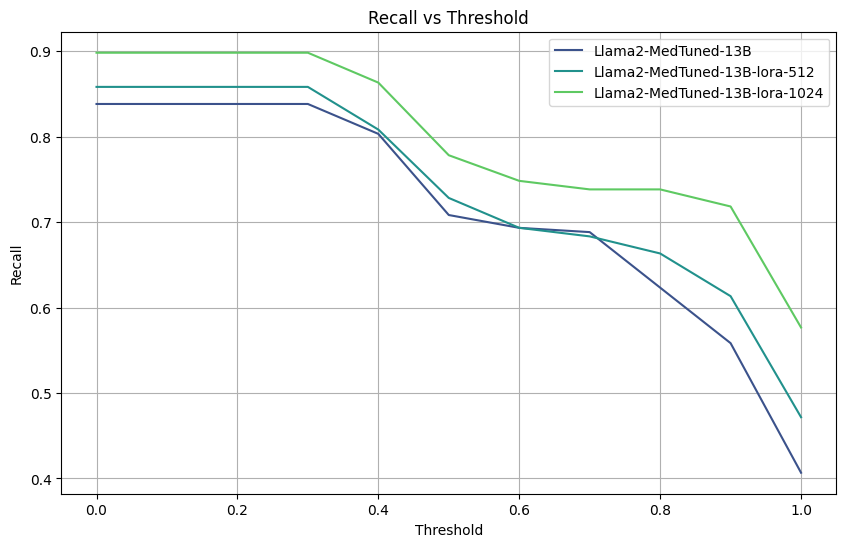

In [54]:
plot_line_plot_group(df_thresholds["threshold"], df_thresholds["side_effects_recall"], df_thresholds["model"], title="Recall vs Threshold", ylabel="Recall", xlabel="Threshold", save_dir = paths.THESIS_PATH/"se_threshold_recall.png")

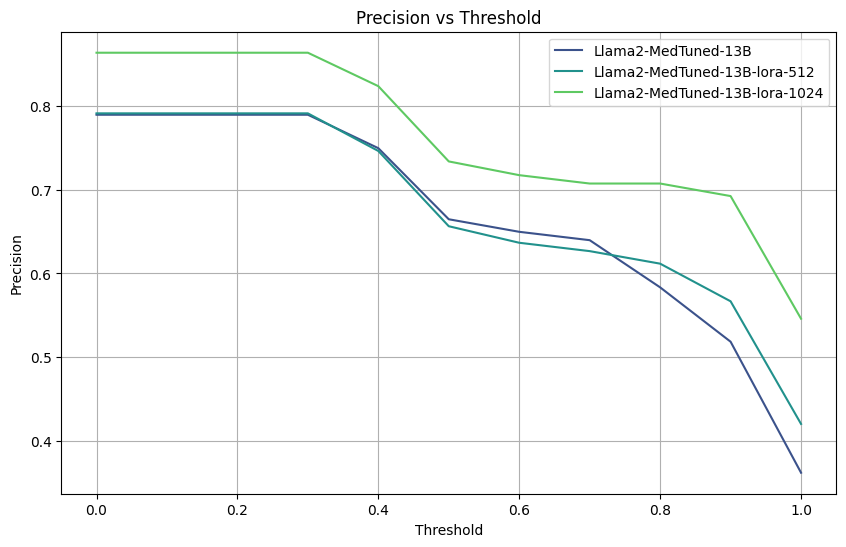

In [55]:
plot_line_plot_group(df_thresholds["threshold"], df_thresholds["side_effects_precision"], df_thresholds["model"], title="Precision vs Threshold", ylabel="Precision", xlabel="Threshold", save_dir = paths.THESIS_PATH/"se_threshold_precision.png")

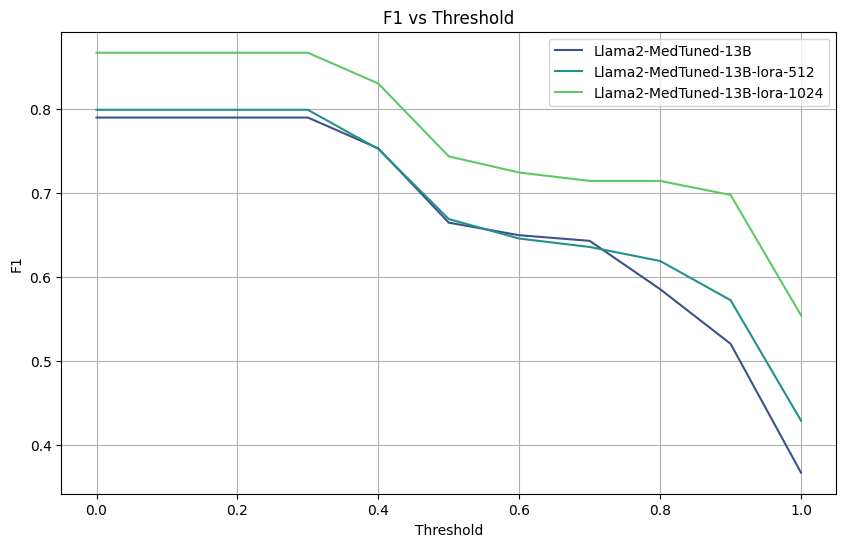

In [56]:
plot_line_plot_group(df_thresholds["threshold"], df_thresholds["side_effects_f1"], df_thresholds["model"], title="F1 vs Threshold", ylabel="F1", xlabel="Threshold", save_dir = paths.THESIS_PATH/"se_threshold_f1.png")

# Examples

In [57]:
res_1024 = prepare_results(paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_instruction_10_examples_s2a.pt")
res_512 = prepare_results(paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_instruction_10_examples_s2a.pt")
res = prepare_results(paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples_s2a.pt")
labels = prepare_labels(paths.RESULTS_PATH/"side-effects/labels.xlsx")

In [58]:
for index, data in res_1024.groupby("index"):
    if len(res_512[res_512["index"] == index]) != len(data):
        print("labels")
        display(labels[labels["index"] == index])
        print("1024")
        display(data)
        print("res")
        display(res[res["index"] == index])
        print("512")
        display(res_512[res_512["index"] == index])
        print("-" * 100)

labels


,index,medication,side_effect,text,original_text
22,17,unknown,unknown,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20..."


1024


,medication,side_effect,text,original_text,index,successful
0,unknown,unknown,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20...",17,true


res


,medication,side_effect,text,original_text,index,successful
0,betaferon,kutanen verhärtungen und grippeähnliche nebenw...,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20...",17,true
1,medrol,lymphozytopenie,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20...",17,true
2,paracetamol,grippeähnliche nebenwirkungen,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20...",17,true
3,phenytoinaufsättigung,intoxikation,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20...",17,true
4,rebif,unknown,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20...",17,true
5,tecfidera,gastrointestinalen nebenwirkungen,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20...",17,true
6,venlafaxin,unknown,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20...",17,true


512


,medication,side_effect,text,original_text,index,successful
0,betaferon,kutanen verhärtungen und grippeähnliche nebenw...,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20...",17,true
1,medrol,lymphozytopenie,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20...",17,true
2,paracetamol,grippeähnliche nebenwirkungen,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20...",17,true
3,phenytoinaufsättigung,intoxikation,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20...",17,true
4,tecfidera,gastrointestinalen nebenwirkungen,"indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw l...","schubförmige multiple sklerose, em am 27.08.20...",17,true


----------------------------------------------------------------------------------------------------
labels


,index,medication,side_effect,text,original_text
27,22,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...


1024


,medication,side_effect,text,original_text,index,successful
0,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true


res


,medication,side_effect,text,original_text,index,successful
0,betaferon,kutanen verhärtungen und grippeähnliche nebenw...,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true
1,gabapentin,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true
2,pantoprazol,grippeähnliche nebenwirkungen,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true
3,paracetamol,grippeähnliche nebenwirkungen,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true
4,phenytoinaufsättigung,intoxikation,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true
5,rebif,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true
6,venlafaxin,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true
7,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true


512


,medication,side_effect,text,original_text,index,successful
0,betaferon,kutanen verhärtungen und grippeähnliche nebenw...,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true
1,medrol,lymphozytopenie,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true
2,paracetamol,grippeähnliche nebenwirkungen,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true
3,phenytoinaufsättigung,intoxikation,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true
4,venlafaxin,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true
5,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,22,true


----------------------------------------------------------------------------------------------------
labels


,index,medication,side_effect,text,original_text
46,40,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...


1024


,medication,side_effect,text,original_text,index,successful
0,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true


res


,medication,side_effect,text,original_text,index,successful
0,betaferon,kutanen verhärtungen und grippeähnliche nebenw...,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true
1,gabapentin,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true
2,pantoprazol,grippeähnliche nebenwirkungen,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true
3,paracetamol,grippeähnliche nebenwirkungen,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true
4,phenytoinaufsättigung,intoxikation,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true
5,rebif,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true
6,venlafaxin,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true
7,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true


512


,medication,side_effect,text,original_text,index,successful
0,betaferon,kutanen verhärtungen und grippeähnliche nebenw...,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true
1,medrol,lymphozytopenie,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true
2,paracetamol,grippeähnliche nebenwirkungen,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true
3,phenytoinaufsättigung,intoxikation,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true
4,venlafaxin,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true
5,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,40,true


----------------------------------------------------------------------------------------------------
labels


,index,medication,side_effect,text,original_text
52,45,unknown,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen


1024


,medication,side_effect,text,original_text,index,successful
0,unknown,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,45,true


res


,medication,side_effect,text,original_text,index,successful
0,paracetamol,grippeähnliche nebenwirkungen,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,45,true


512


,medication,side_effect,text,original_text,index,successful
0,betaferon,kutanen verhärtungen und grippeähnliche nebenw...,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,45,true
1,fumaderm,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,45,true
2,gilenya,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,45,true
3,medrol,lymphozytopenie,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,45,true
4,modasomil/remeron,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,45,true
5,pantoprazol,grippeähnliche nebenwirkungen,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,45,true
6,papyrolien,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,45,true
7,paracetamol,grippeähnliche nebenwirkungen,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,45,true
8,phenytoinaufsättigung,intoxikation,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,45,true
9,rebif,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,45,true


----------------------------------------------------------------------------------------------------
labels


,index,medication,side_effect,text,original_text
64,55,rebif,grippale nebenwirkungen,indent st.n. symptomatischer therapie mit famp...,1. multiple sklerose mit sekundär chronisch pr...
65,55,venlafaxin,unknown,indent st.n. symptomatischer therapie mit famp...,1. multiple sklerose mit sekundär chronisch pr...


1024


,medication,side_effect,text,original_text,index,successful
0,fampyra,unknown,indent st.n. symptomatischer therapie mit famp...,1. multiple sklerose mit sekundär chronisch pr...,55,true
1,modasomil/remeron,keine besserung,indent st.n. symptomatischer therapie mit famp...,1. multiple sklerose mit sekundär chronisch pr...,55,true
2,sirdalud,unknown,indent st.n. symptomatischer therapie mit famp...,1. multiple sklerose mit sekundär chronisch pr...,55,true
3,venlafaxin,unknown,indent st.n. symptomatischer therapie mit famp...,1. multiple sklerose mit sekundär chronisch pr...,55,true


res


,medication,side_effect,text,original_text,index,successful
0,fampyra,unknown,indent st.n. symptomatischer therapie mit famp...,1. multiple sklerose mit sekundär chronisch pr...,55,true
1,sirdalud,unknown,indent st.n. symptomatischer therapie mit famp...,1. multiple sklerose mit sekundär chronisch pr...,55,true
2,venlafaxin,unknown,indent st.n. symptomatischer therapie mit famp...,1. multiple sklerose mit sekundär chronisch pr...,55,true


512


,medication,side_effect,text,original_text,index,successful
0,rebif,unknown,indent st.n. symptomatischer therapie mit famp...,1. multiple sklerose mit sekundär chronisch pr...,55,true


----------------------------------------------------------------------------------------------------
labels


,index,medication,side_effect,text,original_text
67,57,gilenya,unknown,indent seit 02/2007 tysabri 300mg i.v. 1x/mona...,"schubförmige multiple sklerose, ed 1998, edss:..."
68,57,tysabri,eitrige peritonitis,indent seit 02/2007 tysabri 300mg i.v. 1x/mona...,"schubförmige multiple sklerose, ed 1998, edss:..."


1024


,medication,side_effect,text,original_text,index,successful
0,gilenya,angst vor nebenwirkungen,indent seit 02/2007 tysabri 300mg i.v. 1x/mona...,"schubförmige multiple sklerose, ed 1998, edss:...",57,true
1,tysabri,mutmasslicher nebenwirkung in form einer eitri...,indent seit 02/2007 tysabri 300mg i.v. 1x/mona...,"schubförmige multiple sklerose, ed 1998, edss:...",57,true


res


,medication,side_effect,text,original_text,index,successful
0,gilenya,angst vor nebenwirkungen,indent seit 02/2007 tysabri 300mg i.v. 1x/mona...,"schubförmige multiple sklerose, ed 1998, edss:...",57,true
1,tysabri,mutmasslicher nebenwirkung in form einer eitri...,indent seit 02/2007 tysabri 300mg i.v. 1x/mona...,"schubförmige multiple sklerose, ed 1998, edss:...",57,true


512


,medication,side_effect,text,original_text,index,successful
0,fumarsäure,unknown,indent seit 02/2007 tysabri 300mg i.v. 1x/mona...,"schubförmige multiple sklerose, ed 1998, edss:...",57,true
1,gilenya,angst vor nebenwirkungen,indent seit 02/2007 tysabri 300mg i.v. 1x/mona...,"schubförmige multiple sklerose, ed 1998, edss:...",57,true
2,tysabri,mutmasslicher nebenwirkung in form einer eitri...,indent seit 02/2007 tysabri 300mg i.v. 1x/mona...,"schubförmige multiple sklerose, ed 1998, edss:...",57,true


----------------------------------------------------------------------------------------------------
labels


,index,medication,side_effect,text,original_text
69,58,vimpat,unknown,indent erneute anfallserie 02/2010 bei redukti...,symptomatische epilepsie mit einfach- und komp...


1024


,medication,side_effect,text,original_text,index,successful
0,timonil,unknown,indent erneute anfallserie 02/2010 bei redukti...,symptomatische epilepsie mit einfach- und komp...,58,true
1,vimpat,unknown,indent erneute anfallserie 02/2010 bei redukti...,symptomatische epilepsie mit einfach- und komp...,58,true


res


,medication,side_effect,text,original_text,index,successful
0,timonil,anfallserie,indent erneute anfallserie 02/2010 bei redukti...,symptomatische epilepsie mit einfach- und komp...,58,true
1,vimpat,add-on versuch,indent erneute anfallserie 02/2010 bei redukti...,symptomatische epilepsie mit einfach- und komp...,58,true


512


,medication,side_effect,text,original_text,index,successful
0,timonil,nebenwirkungen,indent erneute anfallserie 02/2010 bei redukti...,symptomatische epilepsie mit einfach- und komp...,58,true


----------------------------------------------------------------------------------------------------
labels


,index,medication,side_effect,text,original_text
87,71,unknown,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen


1024


,medication,side_effect,text,original_text,index,successful
0,unknown,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,71,true


res


,medication,side_effect,text,original_text,index,successful
0,paracetamol,grippeähnliche nebenwirkungen,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,71,true


512


,medication,side_effect,text,original_text,index,successful
0,betaferon,kutanen verhärtungen und grippeähnliche nebenw...,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,71,true
1,fumaderm,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,71,true
2,gilenya,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,71,true
3,medrol,lymphozytopenie,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,71,true
4,modasomil/remeron,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,71,true
5,pantoprazol,grippeähnliche nebenwirkungen,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,71,true
6,papyrolien,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,71,true
7,paracetamol,grippeähnliche nebenwirkungen,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,71,true
8,phenytoinaufsättigung,intoxikation,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,71,true
9,rebif,unknown,sonstige unerwünschte nebenwirkungen,sonstige unerwünschte nebenwirkungen,71,true


----------------------------------------------------------------------------------------------------
labels


,index,medication,side_effect,text,original_text
90,74,fampyra,schwindel,indent fampyra aufgrund von nebenwirkungen abg...,multiple sklerose von a.e. primär progrediente...


1024


,medication,side_effect,text,original_text,index,successful
0,fampyra,schwindel,indent fampyra aufgrund von nebenwirkungen abg...,multiple sklerose von a.e. primär progrediente...,74,true


res


,medication,side_effect,text,original_text,index,successful
0,fampyra,schwindel,indent fampyra aufgrund von nebenwirkungen abg...,multiple sklerose von a.e. primär progrediente...,74,true


512


,medication,side_effect,text,original_text,index,successful
0,fampyra,schwindel,indent fampyra aufgrund von nebenwirkungen abg...,multiple sklerose von a.e. primär progrediente...,74,true
1,unknown,unknown,indent fampyra aufgrund von nebenwirkungen abg...,multiple sklerose von a.e. primär progrediente...,74,true


----------------------------------------------------------------------------------------------------
labels


,index,medication,side_effect,text,original_text
99,82,avonex,"stimmungslabilität, leberwerterhöhung, grippal...",indent 11/2014 - 01/2015 rebif (3x44 ug) - weg...,"schubförmige multiple sklerose, ed 2002, edss ..."
100,82,rebif,unknown,indent 11/2014 - 01/2015 rebif (3x44 ug) - weg...,"schubförmige multiple sklerose, ed 2002, edss ..."


1024


,medication,side_effect,text,original_text,index,successful
0,rebif,"stimmungslabilität, leberwerterhöhung, grippal...",indent 11/2014 - 01/2015 rebif (3x44 ug) - weg...,"schubförmige multiple sklerose, ed 2002, edss ...",82,true


res


,medication,side_effect,text,original_text,index,successful
0,rebif,"stimmungslabilität, leberwerterhöhung, grippal...",indent 11/2014 - 01/2015 rebif (3x44 ug) - weg...,"schubförmige multiple sklerose, ed 2002, edss ...",82,true


512


,medication,side_effect,text,original_text,index,successful
0,avonex,unknown,indent 11/2014 - 01/2015 rebif (3x44 ug) - weg...,"schubförmige multiple sklerose, ed 2002, edss ...",82,true
1,rebif,unknown,indent 11/2014 - 01/2015 rebif (3x44 ug) - weg...,"schubförmige multiple sklerose, ed 2002, edss ...",82,true


----------------------------------------------------------------------------------------------------
labels


,index,medication,side_effect,text,original_text
101,83,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...


1024


,medication,side_effect,text,original_text,index,successful
0,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true


res


,medication,side_effect,text,original_text,index,successful
0,betaferon,kutanen verhärtungen und grippeähnliche nebenw...,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true
1,gabapentin,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true
2,pantoprazol,grippeähnliche nebenwirkungen,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true
3,paracetamol,grippeähnliche nebenwirkungen,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true
4,phenytoinaufsättigung,intoxikation,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true
5,rebif,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true
6,venlafaxin,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true
7,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true


512


,medication,side_effect,text,original_text,index,successful
0,betaferon,kutanen verhärtungen und grippeähnliche nebenw...,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true
1,medrol,lymphozytopenie,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true
2,paracetamol,grippeähnliche nebenwirkungen,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true
3,phenytoinaufsättigung,intoxikation,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true
4,venlafaxin,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true
5,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,83,true


----------------------------------------------------------------------------------------------------
labels


,index,medication,side_effect,text,original_text
119,98,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...


1024


,medication,side_effect,text,original_text,index,successful
0,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true


res


,medication,side_effect,text,original_text,index,successful
0,betaferon,kutanen verhärtungen und grippeähnliche nebenw...,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true
1,gabapentin,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true
2,pantoprazol,grippeähnliche nebenwirkungen,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true
3,paracetamol,grippeähnliche nebenwirkungen,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true
4,phenytoinaufsättigung,intoxikation,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true
5,rebif,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true
6,venlafaxin,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true
7,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true


512


,medication,side_effect,text,original_text,index,successful
0,betaferon,kutanen verhärtungen und grippeähnliche nebenw...,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true
1,medrol,lymphozytopenie,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true
2,paracetamol,grippeähnliche nebenwirkungen,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true
3,phenytoinaufsättigung,intoxikation,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true
4,venlafaxin,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true
5,unknown,unknown,unerwünschte nebenwirkung ona arzneimittel ode...,unerwünschte nebenwirkung ona arzneimittel ode...,98,true


----------------------------------------------------------------------------------------------------


Performance difference:
- index 17: 1024 model understand better, when no medication is given like "unerwünschte nebenwirkung ona arzneimittel oder droge", to just put "unknown", meanwhile the other 2 repeated the examples from few-shot
- index 22 another example: "indent labor: crp <0.5 mg/ml, bsr 8 mm/h, nw leukozyten + thrombozyten", also unknown

Good examples:
- index 3
- index 13

Bad examples:
- index: 55; "indent st.n. symptomatischer therapie mit fampyra (insgesamt 2 therapieversuche, gestoppt bei wirkungslosogkeit und i.r. der kardialen vorbefunden), therapieversuch mit modasomil/remeron (keine besserung), venlafaxin (bei nebenwirkungen gestoppt), sirdalud
indent rebif 2002, abgesetzt 6 monate später wegen unverträglichkeit (grippale nebenwirkungen)"; only venlafaxin and rebif have se (model extracts venlafaxin with unknown, misses rebif and puts all the other medications like fampyra, modasomil, remeron, sirdalud

## Good

In [71]:
print(res_1024[res_1024["index"] == "3"][res_1024.columns[:-4]].to_dict(orient = "records"))

[{'medication': 'ciclosporin', 'side_effect': 'niereninsuffizienz'}, {'medication': 'imurek', 'side_effect': 'neutropenie'}, {'medication': 'prednison', 'side_effect': 'osteoporose, diabetes mellitus'}]


In [74]:
print(res_1024[res_1024["index"] == "13"][res_1024.columns[:-4]].to_dict(orient = "records"))

[{'medication': 'tecfidera', 'side_effect': 'gastrointestinalen nebenwirkungen'}]


## Bad

In [75]:
print(res_1024[res_1024["index"] == "22"][res_1024.columns[:-4]].to_dict(orient = "records"))
print(res_512[res_512["index"] == "22"][res_512.columns[:-4]].to_dict(orient = "records"))

[{'medication': 'unknown', 'side_effect': 'unknown'}]
[{'medication': 'betaferon', 'side_effect': 'kutanen verhärtungen und grippeähnliche nebenwirkungen'}, {'medication': 'medrol', 'side_effect': 'lymphozytopenie'}, {'medication': 'paracetamol', 'side_effect': 'grippeähnliche nebenwirkungen'}, {'medication': 'phenytoinaufsättigung', 'side_effect': 'intoxikation'}, {'medication': 'venlafaxin', 'side_effect': 'unknown'}, {'medication': 'unknown', 'side_effect': 'unknown'}]


In [76]:
print(res_1024[res_1024["index"] == "55"][res_1024.columns[:-4]].to_dict(orient = "records"))

[{'medication': 'fampyra', 'side_effect': 'unknown'}, {'medication': 'modasomil/remeron', 'side_effect': 'keine besserung'}, {'medication': 'sirdalud', 'side_effect': 'unknown'}, {'medication': 'venlafaxin', 'side_effect': 'unknown'}]
